# **Auswertung der Energieverbrauchsmessung**
___

In [1]:
#fuer graphische Darstellung
%matplotlib inline

#automatische Aktualisierung von Bibliotheken
%load_ext autoreload    
%autoreload 2

import datetime as dt
import os               #Pfade
import locale           #Spracheinstellung: Deutsch (DE)
locale.setlocale(locale.LC_ALL,'de_DE')

import numpy as np      #Datenmanagement Bibliothek (matritx operationen)
import pandas as pd     #Datenmanagement Bibliothek (wie excel)

import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use(".\src\stylesheets\eb3.mplstyle")     #Style-Vorlagendatei (z.B. Grids, Achsen, Schriftgroeße, etc.)

#eigene Bibliotheken (importiert aus src)
from src.project_definitions import BUID, AREA, WOHNUNGEN, ROOMS, dir_results, area
from src.utilities import recolor_lines, export, truncate_colormap, DIN, INDOC, eb_bbox
from src.update_databases import up
from src.sensor_reader import import_data

### update databases ###
up()

### import databases ###
IND, AMB, EM = import_data()

### export results? True = Export Graphiken für alle Räume + Bauweisen (dauert!) / False = macht nur eine definierte Variante ###
ex  = True

### result path ###
exdir = os.path.join(dir_results,'Energiebedarf')
if not os.path.isdir(exdir):
    os.makedirs(exdir)

16.03.2022 10:47:41 -- INFO -- ------ Starte TinkerForge Update------
16.03.2022 10:47:41 -- INFO -- MH wurde übersprungen.
16.03.2022 10:47:41 -- INFO -- MW wurde übersprungen.
16.03.2022 10:47:41 -- INFO -- LB wurde übersprungen.
16.03.2022 10:47:41 -- INFO -- PM wurde übersprungen.
16.03.2022 10:47:41 -- INFO -- WD wurde übersprungen.
16.03.2022 10:47:41 -- INFO -- ------TinkerForge Update beendet!------
16.03.2022 10:47:41 -- INFO -- Molline-Datenbank up-to-date. Kein Update notwendig.


# **Energieverbrauch**

## **WÄRME**

### **Wärmeenergie (total)**


gesamter Zeitraum
____

C:\Users\Roman\workspace\eb-scripts\eb-data\Results\Energiebedarf\Wärmeenergieverbrauch.pdf saved!


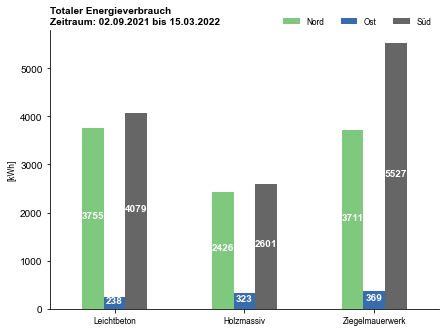

In [2]:
idx = pd.IndexSlice
df = EM.loc(axis=1)[idx[:, ["N", "O", 'S'],'HQ','H']].droplevel([2,3],axis=1)
df = df.resample('365d').last() - df.resample('365d').first()
df.reset_index(drop=True).round(2)
fig,ax = plt.subplots(figsize=INDOC)
df.stack().T.droplevel(0,axis=1).plot.bar(ax=ax,cmap = 'Accent')
ax.set_title(f'Totaler Energieverbrauch\nZeitraum: {(EM.index.min().strftime("%d.%m.%Y"))} bis {EM.index.max().strftime("%d.%m.%Y")}', fontweight = 'bold')
ax.set_ylabel('[kWh]')
ax.set_xticklabels(['Leichtbeton', 'Holzmassiv', 'Ziegelmauerwerk'], rotation=0)
ax.grid(False)
ax.legend(labels=['Nord','Ost','Süd'],loc='center right',ncol=99,bbox_to_anchor=(1,1.03),frameon=False)
xticks=[]
for bar in ax.patches:
    xticks.append(bar.get_x())
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height()*0.5 + bar.get_y(),
        f"{round(bar.get_height(),0):.0f}",
        ha='center',
        color='w',
        weight='bold',
        )

fig.tight_layout()
if ex:
    export(fig,exdir,'Wärmeenergieverbrauch',extlist=['pdf'], show=True)

### **Wärmeenergie (spezifisch)**


Winter
____

C:\Users\Roman\workspace\eb-scripts\eb-data\Results\Energiebedarf\Wärmeenergieverbrauch_spezifisch_Winter.pdf saved!


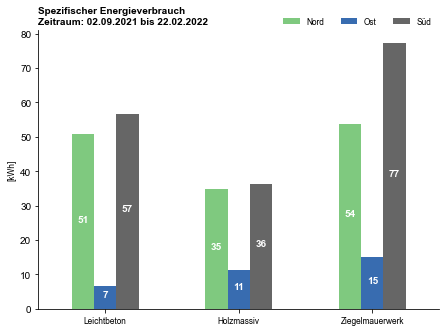

In [3]:
idx = pd.IndexSlice
startdate = dt.datetime(2021,9,2)
enddate = dt.datetime(2022,2,22)
df = EM.loc(axis=1)[idx[:, ["N", "O", 'S'],'HQ','H']].droplevel([2,3],axis=1)
df = df.loc[startdate:enddate]
df = df.resample('5000d').last() - df.resample('5000d').first()
df = df.reset_index(drop=True).div(AREA,level=1).round(2)
fig,ax = plt.subplots(figsize=INDOC)
df.stack().T.droplevel(0,axis=1).plot.bar(ax=ax,cmap = 'Accent')
ax.set_title(f'Spezifischer Energieverbrauch\nZeitraum: {(startdate.strftime("%d.%m.%Y"))} bis {enddate.strftime("%d.%m.%Y")}', fontweight = 'bold')
ax.set_ylabel('[kWh]')
ax.set_xticklabels(['Leichtbeton', 'Holzmassiv', 'Ziegelmauerwerk'], rotation=0)
ax.grid(False)
ax.legend(labels=['Nord','Ost','Süd'],loc='center right',ncol=99,bbox_to_anchor=(1,1.03),frameon=False)
xticks=[]
for bar in ax.patches:
    xticks.append(bar.get_x())
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height()*0.5 + bar.get_y(),
        f"{round(bar.get_height(),0):.0f}",
        ha='center',
        color='w',
        weight='bold',
        )

fig.tight_layout()
if ex:
    export(fig,exdir,'Wärmeenergieverbrauch_spezifisch_Winter',extlist=['pdf'], show=True)

gesamter Zeitraum
___

C:\Users\Roman\workspace\eb-scripts\eb-data\Results\Energiebedarf\spezifischer_Wärmeenergieverbrauch.pdf saved!


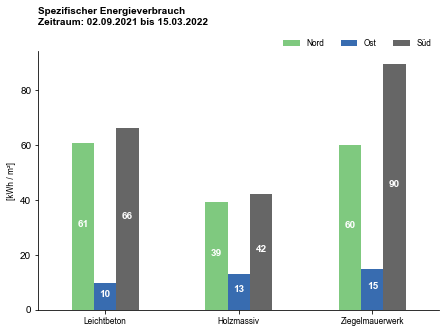

In [4]:
idx = pd.IndexSlice
df = EM.loc(axis=1)[idx[:, ["N", "O",'S'],'HQ','H']].droplevel([2,3],axis=1)
df = df.resample('365d').last() - df.resample('365d').first()
df = df.reset_index(drop=True).div(AREA,level=1).round(2)
fig,ax = plt.subplots(figsize=INDOC)
df.stack().T.droplevel(0,axis=1).plot.bar(ax=ax,cmap = 'Accent')
ax.set_title(f'Spezifischer Energieverbrauch\nZeitraum: {(EM.index.min().strftime("%d.%m.%Y"))} bis {EM.index.max().strftime("%d.%m.%Y")}', fontweight = 'bold', y=1.08)
ax.set_ylabel('[kWh / m²]')
ax.set_xticklabels(['Leichtbeton', 'Holzmassiv', 'Ziegelmauerwerk'], rotation=0)
ax.grid(False)
ax.legend(labels=['Nord','Ost','Süd'],loc='center right',ncol=99,bbox_to_anchor=(1,1.03),frameon=False)
xticks=[]
for bar in ax.patches:
    xticks.append(bar.get_x())
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height()*0.5 + bar.get_y(),
        f"{bar.get_height():.0f}",
        ha='center',
        color='w',
        weight='bold',
        )

fig.tight_layout()
if ex:
    export(fig,exdir,'spezifischer_Wärmeenergieverbrauch',extlist=['pdf'], show=True)

### **Wärmeenergie (kumuliert)**

gesamter Zeitraum
____

C:\Users\Roman\workspace\eb-scripts\eb-data\Results\Energiebedarf\Wärmeenergieverbrauch_kumuliert.pdf saved!


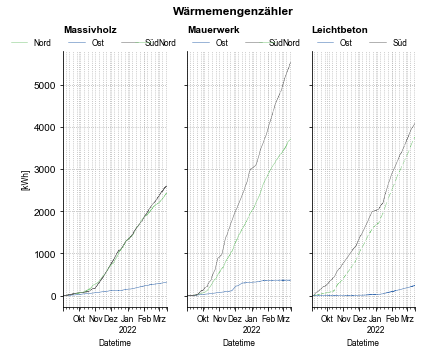

In [5]:
fig, axs = plt.subplots(1,3,sharex=True, sharey=True,figsize=INDOC)
fig.suptitle(f'Wärmemengenzähler',y=1.01)
for b, bui in enumerate(BUID):
    df = EM.loc(axis=1)[idx[bui,['N','O','S'],'HQ','H']].droplevel([0,2,3],axis=1).resample('H').last()
    (df - df.min()).plot(ax=axs[b], cmap = 'Accent')
    axs[b].legend(labels=['Nord','Ost','Süd'],loc='center right',ncol=99,bbox_to_anchor=(1,1.03),frameon=False)
    axs[b].set_title(f'{BUID[bui]}',y=1.05)
axs[0].set_ylabel(f'[kWh]')
if ex:
    export(fig,exdir,'Wärmeenergieverbrauch_kumuliert',extlist=['pdf'], show=True)

## **STROM**

### Stromverbrauch (spezifisch)

C:\Users\Roman\workspace\eb-scripts\eb-data\Results\Energiebedarf\Stromverbrauch_spezifisch_normalisiert.pdf saved!


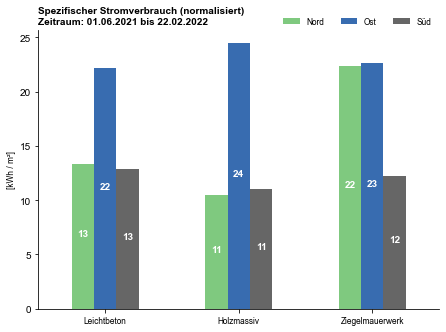

In [6]:
Normalize = True

Stromverbrauch = pd.read_csv('.\src\Stromzähler.csv', header=[0,1], index_col=[0], sep=';')
Stromverbrauch.index = pd.to_datetime(Stromverbrauch.index,format='%d.%m.%Y')
if Normalize:
    start = dt.datetime(2021,6,1)
    sollT = dt.date.today()-start.date()
    dfs=[]
    idx=[]
    for name, group in Stromverbrauch.groupby(level=[0,1],axis=1):
        group = group.dropna()
        deltaT = group.index.max()-group.index.min()
        df = (group.max() / deltaT.days) * sollT.days
        cols = df.index
        idx.extend(cols)
        dfs.append(df.values)
    idx = pd.MultiIndex.from_tuples(idx)
    date = group.index
    df = pd.DataFrame(dfs, index=idx, columns=[group.index.max()]).T
else:
    df = pd.DataFrame(Stromverbrauch.loc[Stromverbrauch.index.max(),:]).T
    date = Stromverbrauch.index

df = df.reset_index(drop=True).div(AREA,level=1).round(2)


df = df.stack().T.droplevel(0,axis=1)

fig,ax = plt.subplots(figsize=INDOC)
df.plot.bar(ax=ax,cmap = 'Accent')

if Normalize:
    title = 'Spezifischer Stromverbrauch (normalisiert)'
    fname = 'normalisiert'
    ax.set_title(f'{title}\nZeitraum: {start.strftime("%d.%m.%Y")} bis {date.max().strftime("%d.%m.%Y")}', fontweight = 'bold')
else:
    title = 'Spezifischer Stromverbrauch (absolut)'
    fname = 'absolut'
    ax.set_title(f'{title}\nletztes Ablesedatum: {date.max().strftime("%d.%m.%Y")}', fontweight = 'bold')
ax.set_ylabel('[kWh / m²]')
ax.set_xticklabels(['Leichtbeton', 'Holzmassiv', 'Ziegelmauerwerk'], rotation=0)
ax.grid(False)
ax.legend(labels=['Nord','Ost','Süd'],loc='center right',ncol=99,bbox_to_anchor=(1,1.03),frameon=False)
xticks=[]
for bar in ax.patches:
    xticks.append(bar.get_x())

    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height()*0.5 + bar.get_y(),
        f"{round(bar.get_height(),0):.0f}",
        ha='center',
        color='w',
        weight='bold',
        )

fig.tight_layout()
if ex:
    export(fig,exdir,f'Stromverbrauch_spezifisch_{fname}',extlist=['pdf'], show=True)

### Stromverbrauch (gesamt)

C:\Users\Roman\workspace\eb-scripts\eb-data\Results\Energiebedarf\Stromverbrauch_total_normalisiert.pdf saved!


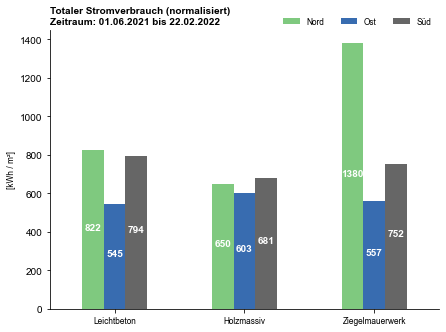

In [7]:
Normalize = True

Stromverbrauch = pd.read_csv('.\src\Stromzähler.csv', header=[0,1], index_col=[0], sep=';')
Stromverbrauch.index = pd.to_datetime(Stromverbrauch.index,format='%d.%m.%Y')
if Normalize:
    start = dt.datetime(2021,6,1)
    sollT = dt.date.today()-start.date()
    dfs=[]
    idx=[]
    for name, group in Stromverbrauch.groupby(level=[0,1],axis=1):
        group = group.dropna()
        deltaT = group.index.max()-group.index.min()
        df = (group.max() / deltaT.days) * sollT.days
        cols = df.index
        idx.extend(cols)
        dfs.append(df.values)
    idx = pd.MultiIndex.from_tuples(idx)
    date = group.index
    df = pd.DataFrame(dfs, index=idx, columns=[group.index.max()]).T
else:
    df = pd.DataFrame(Stromverbrauch.loc[Stromverbrauch.index.max(),:]).T
    date = Stromverbrauch.index

df = df.stack().T.droplevel(0,axis=1)

fig,ax = plt.subplots(figsize=INDOC)
df.plot.bar(ax=ax,cmap = 'Accent')

if Normalize:
    title = 'Totaler Stromverbrauch (normalisiert)'
    fname = 'normalisiert'
    ax.set_title(f'{title}\nZeitraum: {start.strftime("%d.%m.%Y")} bis {date.max().strftime("%d.%m.%Y")}', fontweight = 'bold')
else:
    title = 'Totaler Stromverbrauch (absolut)'
    fname = 'absolut'
    ax.set_title(f'{title}\nletztes Ablesedatum: {date.max().strftime("%d.%m.%Y")}', fontweight = 'bold')
ax.set_ylabel('[kWh / m²]')
ax.set_xticklabels(['Leichtbeton', 'Holzmassiv', 'Ziegelmauerwerk'], rotation=0)
ax.grid(False)
ax.legend(labels=['Nord','Ost','Süd'],loc='center right',ncol=99,bbox_to_anchor=(1,1.03),frameon=False)
xticks=[]
for bar in ax.patches:
    xticks.append(bar.get_x())

    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height()*0.5 + bar.get_y(),
        f"{round(bar.get_height(),0):.0f}",
        ha='center',
        color='w',
        weight='bold',
        )

fig.tight_layout()
if ex:
    export(fig,exdir,f'Stromverbrauch_total_{fname}',extlist=['pdf'], show=True)

### Stromverbrauch (Winter)

C:\Users\Roman\workspace\eb-scripts\eb-data\Results\Energiebedarf\Stromverbrauch_total_Winter.pdf saved!


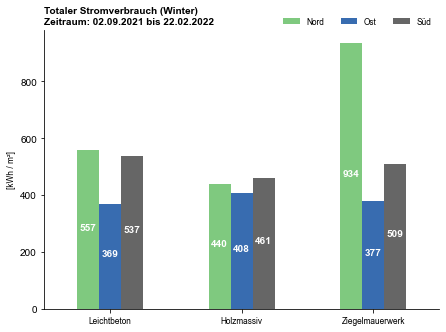

In [8]:
Normalize = True

Stromverbrauch = pd.read_csv('.\src\Stromzähler.csv', header=[0,1], index_col=[0], sep=';')
Stromverbrauch.index = pd.to_datetime(Stromverbrauch.index,format='%d.%m.%Y')
if Normalize:
    start = dt.datetime(2021,9,2)
    sollT = dt.date.today()-start.date()
    dfs=[]
    idx=[]
    for name, group in Stromverbrauch.groupby(level=[0,1],axis=1):
        group = group.dropna()
        deltaT = group.index.max()-group.index.min()
        df = (group.max() / deltaT.days) * sollT.days
        cols = df.index
        idx.extend(cols)
        dfs.append(df.values)
    idx = pd.MultiIndex.from_tuples(idx)
    date = group.index
    df = pd.DataFrame(dfs, index=idx, columns=[group.index.max()]).T
else:
    df = pd.DataFrame(Stromverbrauch.loc[Stromverbrauch.index.max(),:]).T
    date = Stromverbrauch.index

df = df.stack().T.droplevel(0,axis=1)

fig,ax = plt.subplots(figsize=INDOC)
df.plot.bar(ax=ax,cmap = 'Accent')

if Normalize:
    title = 'Totaler Stromverbrauch (Winter)'
    fname = 'Winter'
    ax.set_title(f'{title}\nZeitraum: {start.strftime("%d.%m.%Y")} bis {date.max().strftime("%d.%m.%Y")}', fontweight = 'bold')
else:
    title = 'Totaler Stromverbrauch (absolut)'
    fname = 'absolut'
    ax.set_title(f'{title}\nletztes Ablesedatum: {date.max().strftime("%d.%m.%Y")}', fontweight = 'bold')
ax.set_ylabel('[kWh / m²]')
ax.set_xticklabels(['Leichtbeton', 'Holzmassiv', 'Ziegelmauerwerk'], rotation=0)
ax.grid(False)
ax.legend(labels=['Nord','Ost','Süd'],loc='center right',ncol=99,bbox_to_anchor=(1,1.03),frameon=False)
xticks=[]
for bar in ax.patches:
    xticks.append(bar.get_x())

    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height()*0.5 + bar.get_y(),
        f"{round(bar.get_height(),0):.0f}",
        ha='center',
        color='w',
        weight='bold',
        )

fig.tight_layout()
if ex:
    export(fig,exdir,f'Stromverbrauch_total_{fname}',extlist=['pdf'], show=True)